In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

/Users/narimatsu_n/.pyenv/versions/3.5.0/lib/python3.5/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df_train = pd.read_csv('./input/train.csv')
df_test = pd.read_csv('./input/test.csv')
df_hist_trans = pd.read_csv('./input/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('./input/new_merchant_transactions.csv')

In [3]:
df_hist_trans['purchase_amount'] = np.exp(df_hist_trans['purchase_amount'])
df_new_merchant_trans['purchase_amount'] = np.exp(df_new_merchant_trans['purchase_amount'])

In [4]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [5]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [6]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [7]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

152

In [8]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

152

In [9]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_category_3_mean_mean,hist_month_diff_mean,hist_subsector_id_nunique,hist_month_lag_max,...,new_hist_category_3_mean_mean,new_hist_installments_sum,new_hist_installments_max,new_hist_installments_min,new_hist_installments_mean,new_hist_installments_var,new_hist_dayofweek_nunique,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,inf,9.623077,21,0,...,1.381361e+36,0.0,0.0,0.0,0.000000,0.000000,7.0,54.0,2.347826,227.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,inf,10.580000,24,0,...,3.557623e+25,6.0,1.0,1.0,1.000000,0.000000,4.0,56.0,9.333333,258.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,inf,9.488372,7,0,...,1.381361e+36,0.0,0.0,0.0,0.000000,NaN,1.0,0.0,0.000000,228.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,inf,9.519481,13,0,...,1.973373e+35,5.0,1.0,-1.0,0.714286,0.571429,4.0,41.0,5.857143,238.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,inf,9.541353,17,0,...,3.624714e+107,35.0,2.0,-1.0,0.972222,0.142063,7.0,57.0,1.583333,228.0


In [10]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [11]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [12]:
high_importance_features = [
    "hist_month_diff_mean", 
    "hist_authorized_flag_mean", 
    "hist_category_1_sum", 
    "hist_month_lag_mean", 
    "new_hist_purchase_amount_sum", 
    "new_hist_purchase_date_uptonow"
]

#smoothing
for col in high_importance_features:
    df_train[col] = np.where(df_train[col].values==0, 0.001, df_train[col].values)
    df_test[col] = np.where(df_test[col].values==0, 0.001, df_test[col].values)


for i in range(len(high_importance_features)):
    for j in range(len((high_importance_features)))[i+1:]:
        col1 = high_importance_features[i]
        col2 = high_importance_features[j]
        new_col_name = "{c1}__div__{c2}".format(c1=col1, c2=col2)
        
        df_train[new_col_name] = df_train[col1] / df_train[col2]
        df_test[new_col_name] = df_test[col1] / df_test[col2]

In [13]:
merchant_feature = pd.read_csv("./input/merchants_nmf.csv")

df_train = pd.merge(df_train, merchant_feature, on="card_id", how="left")
df_test = pd.merge(df_test, merchant_feature, on="card_id", how="left")

In [14]:
new_merchant_feature = pd.read_csv("./input/new_merchants_nmf.csv")

df_train = pd.merge(df_train, new_merchant_feature, on="card_id", how="left")
df_test = pd.merge(df_test, new_merchant_feature, on="card_id", how="left")

In [15]:
prosperity = pd.read_csv("./input/prosperity_merchants_latest.csv")

df_train = pd.merge(df_train, prosperity, on="card_id", how="left")
df_test = pd.merge(df_test, prosperity, on="card_id", how="left")

In [16]:
merchants_numerical = pd.read_csv("./input/merchants_numerical_features.csv")

df_train = pd.merge(df_train, merchants_numerical, on="card_id", how="left")
df_test = pd.merge(df_test, merchants_numerical, on="card_id", how="left")

In [17]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

In [18]:
#original
param = {'num_leaves': 31, #31
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.004,
         "min_child_samples": 18, #20
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.74194	valid_1's rmse: 3.77742
[200]	training's rmse: 3.67504	valid_1's rmse: 3.73319
[300]	training's rmse: 3.62817	valid_1's rmse: 3.70853
[400]	training's rmse: 3.59232	valid_1's rmse: 3.69403
[500]	training's rmse: 3.56387	valid_1's rmse: 3.68335
[600]	training's rmse: 3.54068	valid_1's rmse: 3.67646
[700]	training's rmse: 3.52096	valid_1's rmse: 3.67105
[800]	training's rmse: 3.50337	valid_1's rmse: 3.6671
[900]	training's rmse: 3.4876	valid_1's rmse: 3.66427
[1000]	training's rmse: 3.47297	valid_1's rmse: 3.6616
[1100]	training's rmse: 3.45898	valid_1's rmse: 3.6595
[1200]	training's rmse: 3.44587	valid_1's rmse: 3.6577
[1300]	training's rmse: 3.43368	valid_1's rmse: 3.65576
[1400]	training's rmse: 3.4224	valid_1's rmse: 3.65467
[1500]	training's rmse: 3.41139	valid_1's rmse: 3.6536
[1600]	training's rmse: 3.40111	valid_1's rmse: 3.65277
[1700]	training's rmse: 3.39057	valid_1's rmse: 3.

[3900]	training's rmse: 3.21444	valid_1's rmse: 3.64688
[4000]	training's rmse: 3.20832	valid_1's rmse: 3.64688
[4100]	training's rmse: 3.20216	valid_1's rmse: 3.64694
[4200]	training's rmse: 3.19566	valid_1's rmse: 3.64688
[4300]	training's rmse: 3.18959	valid_1's rmse: 3.64678
[4400]	training's rmse: 3.18376	valid_1's rmse: 3.64674
[4500]	training's rmse: 3.17796	valid_1's rmse: 3.64685
[4600]	training's rmse: 3.17162	valid_1's rmse: 3.64665
[4700]	training's rmse: 3.16579	valid_1's rmse: 3.64679
[4800]	training's rmse: 3.15974	valid_1's rmse: 3.64684
[4900]	training's rmse: 3.15398	valid_1's rmse: 3.64669
[5000]	training's rmse: 3.148	valid_1's rmse: 3.64679
Early stopping, best iteration is:
[4602]	training's rmse: 3.17149	valid_1's rmse: 3.64663
fold 3
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.74259	valid_1's rmse: 3.76883
[200]	training's rmse: 3.67481	valid_1's rmse: 3.72731
[300]	training's rmse: 3.6273	valid_1's rmse: 3.70469
[400]

3.646398884244033

In [21]:
# score:  3.6458692529031196

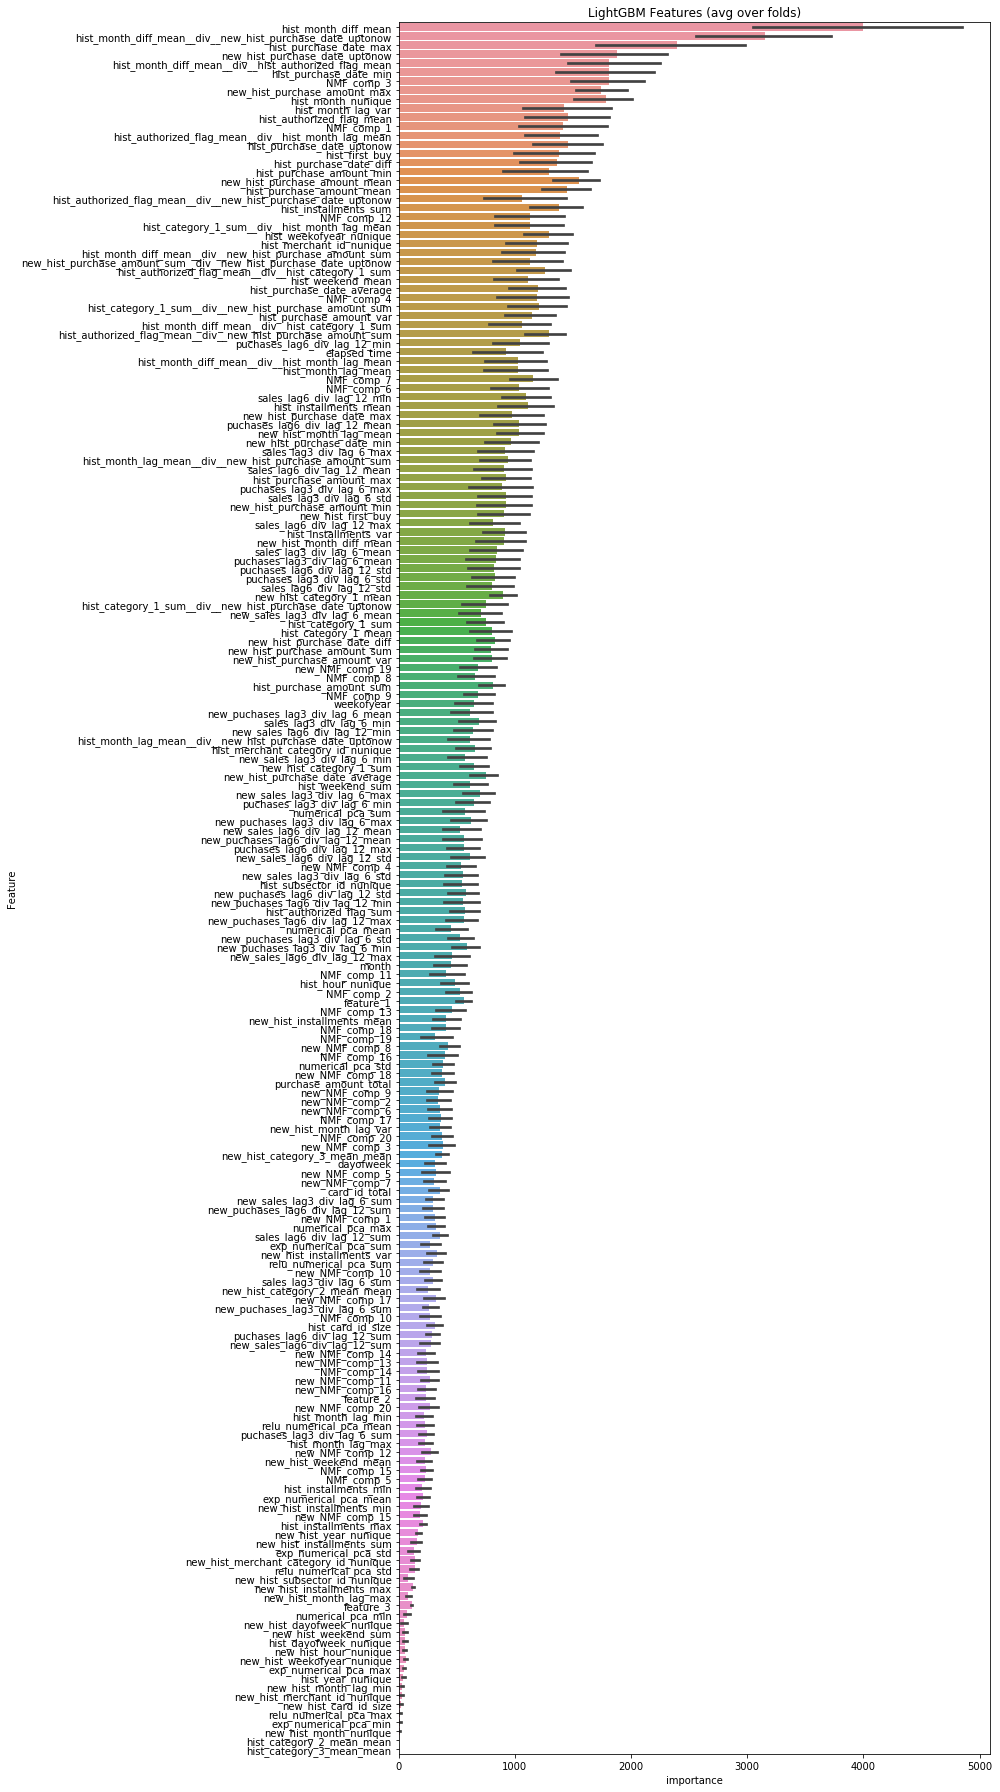

In [22]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [23]:
# import optuna

# def objective(trial):
#     train_x, test_x, train_y, test_y = train_test_split(df_train[df_train_columns], target, test_size=0.25, random_state=4590)
#     dtrain = lgb.Dataset(train_x, label=train_y)

#     num_round = trial.suggest_int('num_round', 1, 1000)
#     param = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'bagging_seed':11, 'random_state':4590,
#              'boosting_type': trial.suggest_categorical('boosting', ['gbdt']),
#              'num_leaves': trial.suggest_int('num_leaves', 10, 100),
#              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1e-1),
#              'min_data_in_leaf': 30,
#              'min_child_samples': trial.suggest_loguniform('min_child_samples', 10, 1000),
#              'feature_fraction': trial.suggest_loguniform('feature_fraction', 0.8, 1.0),
#              'bagging_fraction': trial.suggest_loguniform('bagging_fraction', 0.8, 1.0),
#              }

#     gbm = lgb.train(param, dtrain, num_round)
#     preds = gbm.predict(test_x)
#     pred_labels = np.rint(preds)
#     rmse = np.sqrt(mean_squared_error(test_y, pred_labels))
#     return rmse

# study = optuna.create_study()
# study.optimize(objective, n_trials=20)

# print('Number of finished trials: {}'.format(len(study.trials)))

# print('Best trial:')
# trial = study.best_trial

# print('  Value: {}'.format(trial.value))

# print('  Params: ')
# for key, value in trial.params.items():
#     print('    {}: {}'.format(key, value))

In [24]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("./output/submission_model20181212.csv", index=False)